<a href="https://colab.research.google.com/github/Khushgod/Drug_Side_Effects_Analysis/blob/main/Drug_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

class DrugAnalysisPipeline:
    def __init__(self, data_path):
        """
        Initialize the Drug Analysis Pipeline

        Parameters:
        data_path (str): Path to the CSV file containing drug data
        """
        self.data_path = data_path
        self.df = None
        self.processed_data = {}

    def load_and_explore_data(self):
        """Load data and perform initial exploration"""
        print("="*60)
        print("LOADING AND EXPLORING DATA")
        print("="*60)

        # Load data
        self.df = pd.read_csv(self.data_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")

        # Basic info
        print("\n" + "="*40)
        print("DATASET OVERVIEW")
        print("="*40)
        print(f"Total drugs: {self.df['drug_name'].nunique()}")
        print(f"Total medical conditions: {self.df['medical_condition'].nunique()}")
        print(f"Total drug classes: {self.df['drug_classes'].nunique()}")

        # Data types and missing values
        print("\n" + "="*40)
        print("DATA QUALITY ASSESSMENT")
        print("="*40)
        missing_data = self.df.isnull().sum()
        print("Missing values per column:")
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"  {col}: {missing} ({missing/len(self.df)*100:.2f}%)")

        # Display first few rows
        print("\n" + "="*40)
        print("SAMPLE DATA")
        print("="*40)
        print(self.df.head())

        return self.df

    def analyze_drug_condition_relationships(self):
        """Analyze relationships between drugs and medical conditions"""
        print("\n" + "="*60)
        print("ANALYZING DRUG-CONDITION RELATIONSHIPS")
        print("="*60)

        # Drugs per condition
        condition_drug_count = self.df.groupby('medical_condition')['drug_name'].nunique().sort_values(ascending=False)
        print("Top 10 conditions with most drug options:")
        print(condition_drug_count.head(10))

        # Conditions per drug
        drug_condition_count = self.df.groupby('drug_name')['medical_condition'].nunique().sort_values(ascending=False)
        multi_condition_drugs = drug_condition_count[drug_condition_count > 1]
        print(f"\nDrugs treating multiple conditions: {len(multi_condition_drugs)}")
        print("Top drugs treating multiple conditions:")
        print(multi_condition_drugs.head(10))

        # Store results
        self.processed_data['condition_drug_count'] = condition_drug_count
        self.processed_data['drug_condition_count'] = drug_condition_count

        return condition_drug_count, drug_condition_count

    def analyze_side_effects(self):
        """Analyze side effects patterns"""
        print("\n" + "="*60)
        print("ANALYZING SIDE EFFECTS PATTERNS")
        print("="*60)

        # Clean and process side effects
        side_effects_data = self.df[self.df['side_effects'].notna()].copy()

        if len(side_effects_data) > 0:
            # Split side effects and create frequency analysis
            all_effects = []
            for effects in side_effects_data['side_effects']:
                if pd.notna(effects):
                    # Split by common delimiters
                    effects_list = str(effects).replace(',', ';').replace('and', ';').split(';')
                    all_effects.extend([effect.strip().lower() for effect in effects_list if effect.strip()])

            effect_counts = pd.Series(all_effects).value_counts()
            print("Most common side effects:")
            print(effect_counts.head(15))

            # Side effects by drug class
            drug_class_effects = {}
            for idx, row in side_effects_data.iterrows():
                drug_class = row['drug_classes']
                effects = str(row['side_effects'])
                if drug_class not in drug_class_effects:
                    drug_class_effects[drug_class] = []
                drug_class_effects[drug_class].extend([e.strip().lower() for e in effects.replace(',', ';').split(';') if e.strip()])

            print(f"\nDrug classes analyzed for side effects: {len(drug_class_effects)}")

            self.processed_data['effect_counts'] = effect_counts
            self.processed_data['drug_class_effects'] = drug_class_effects

        return effect_counts if len(side_effects_data) > 0 else None

    def analyze_ratings_and_reviews(self):
        """Analyze drug ratings and review patterns"""
        print("\n" + "="*60)
        print("ANALYZING RATINGS AND REVIEWS")
        print("="*60)

        # Clean rating data
        rating_data = self.df[self.df['rating'].notna()].copy()
        review_data = self.df[self.df['no_of_reviews'].notna()].copy()

        if len(rating_data) > 0:
            # Basic rating statistics
            print("Rating Statistics:")
            print(f"  Mean rating: {rating_data['rating'].mean():.2f}")
            print(f"  Median rating: {rating_data['rating'].median():.2f}")
            print(f"  Std deviation: {rating_data['rating'].std():.2f}")
            print(f"  Range: {rating_data['rating'].min():.1f} - {rating_data['rating'].max():.1f}")

            # Ratings by drug class
            class_ratings = rating_data.groupby('drug_classes')['rating'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)
            print("\nTop 10 drug classes by average rating:")
            print(class_ratings.head(10))

            # Ratings by medical condition
            condition_ratings = rating_data.groupby('medical_condition')['rating'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)
            print("\nTop 10 medical conditions by average drug rating:")
            print(condition_ratings.head(10))

        if len(review_data) > 0:
            # Review statistics
            print(f"\nReview Statistics:")
            print(f"  Total reviews: {review_data['no_of_reviews'].sum():,}")
            print(f"  Mean reviews per drug: {review_data['no_of_reviews'].mean():.1f}")
            print(f"  Median reviews per drug: {review_data['no_of_reviews'].median():.1f}")

            # Most reviewed drugs
            most_reviewed = review_data.nlargest(10, 'no_of_reviews')[['drug_name', 'medical_condition', 'no_of_reviews', 'rating']]
            print("\nMost reviewed drugs:")
            print(most_reviewed)

        # Store results
        if len(rating_data) > 0:
            self.processed_data['rating_stats'] = {
                'class_ratings': class_ratings,
                'condition_ratings': condition_ratings,
                'overall_stats': rating_data['rating'].describe()
            }

        return rating_data if len(rating_data) > 0 else None

    def analyze_drug_safety_profiles(self):
        """Analyze drug safety based on pregnancy category, CSA schedule, alcohol interactions"""
        print("\n" + "="*60)
        print("ANALYZING DRUG SAFETY PROFILES")
        print("="*60)

        # Pregnancy category analysis
        if 'pregnancy_category' in self.df.columns:
            pregnancy_dist = self.df['pregnancy_category'].value_counts()
            print("Pregnancy Category Distribution:")
            print(pregnancy_dist)

        # CSA schedule analysis
        if 'csa' in self.df.columns:
            csa_dist = self.df['csa'].value_counts()
            print("\nControlled Substances Act Schedule Distribution:")
            print(csa_dist)

        # Alcohol interaction analysis
        if 'alcohol' in self.df.columns:
            alcohol_dist = self.df['alcohol'].value_counts()
            print("\nAlcohol Interaction Distribution:")
            print(alcohol_dist)

        # Rx/OTC distribution
        if 'rx_otc' in self.df.columns:
            rx_otc_dist = self.df['rx_otc'].value_counts()
            print("\nPrescription Status Distribution:")
            print(rx_otc_dist)

        # Safety score calculation (composite)
        safety_data = self.df.copy()
        safety_score = []

        for idx, row in safety_data.iterrows():
            score = 0
            # Pregnancy safety (higher is safer)
            if row.get('pregnancy_category') == 'A':
                score += 3
            elif row.get('pregnancy_category') == 'B':
                score += 2
            elif row.get('pregnancy_category') == 'C':
                score += 1
            elif row.get('pregnancy_category') in ['D', 'X']:
                score -= 1

            # CSA schedule (lower number = higher abuse potential = less safe)
            csa = str(row.get('csa', 'N'))
            if csa == 'N':
                score += 2
            elif csa in ['4', '5']:
                score += 1
            elif csa in ['1', '2', '3']:
                score -= 1

            # Alcohol interaction
            if row.get('alcohol') != 'X':
                score += 1
            else:
                score -= 1

            safety_score.append(score)

        safety_data['safety_score'] = safety_score

        print(f"\nSafety Score Distribution (higher is safer):")
        print(f"  Mean: {np.mean(safety_score):.2f}")
        print(f"  Range: {min(safety_score)} to {max(safety_score)}")

        self.processed_data['safety_analysis'] = {
            'safety_scores': safety_data[['drug_name', 'safety_score']],
            'pregnancy_dist': pregnancy_dist if 'pregnancy_category' in self.df.columns else None,
            'csa_dist': csa_dist if 'csa' in self.df.columns else None
        }

        return safety_data

    def create_drug_network_analysis(self):
        """Create network analysis of drug relationships"""
        print("\n" + "="*60)
        print("CREATING DRUG NETWORK ANALYSIS")
        print("="*60)

        # Create drug-condition network
        G = nx.Graph()

        # Add nodes and edges
        for idx, row in self.df.iterrows():
            drug = row['drug_name']
            condition = row['medical_condition']
            drug_class = row.get('drug_classes', 'Unknown')

            # Add nodes with attributes
            G.add_node(drug, type='drug', drug_class=drug_class)
            G.add_node(condition, type='condition')

            # Add edge with weight (could be based on rating or reviews)
            weight = row.get('rating', 1.0) if pd.notna(row.get('rating')) else 1.0
            G.add_edge(drug, condition, weight=weight)

        print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

        # Calculate network metrics
        drug_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'drug']
        condition_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'condition']

        print(f"Drug nodes: {len(drug_nodes)}")
        print(f"Condition nodes: {len(condition_nodes)}")

        # Calculate centrality measures for drugs
        degree_centrality = nx.degree_centrality(G)
        drug_centrality = {drug: degree_centrality[drug] for drug in drug_nodes}

        # Most connected drugs
        top_connected_drugs = sorted(drug_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nMost connected drugs (treat multiple conditions):")
        for drug, centrality in top_connected_drugs:
            print(f"  {drug}: {centrality:.3f}")

        self.processed_data['network_analysis'] = {
            'graph': G,
            'drug_centrality': drug_centrality,
            'top_connected_drugs': top_connected_drugs
        }

        return G

    def perform_clustering_analysis(self):
        """Perform clustering analysis on drugs based on multiple features"""
        print("\n" + "="*60)
        print("PERFORMING CLUSTERING ANALYSIS")
        print("="*60)

        # Prepare features for clustering
        clustering_data = self.df.copy()

        # Encode categorical variables
        le_condition = LabelEncoder()
        le_drug_class = LabelEncoder()
        le_rx_otc = LabelEncoder()

        # Create feature matrix
        features = []
        feature_names = []

        # Medical condition encoded
        if 'medical_condition' in clustering_data.columns:
            clustering_data['condition_encoded'] = le_condition.fit_transform(clustering_data['medical_condition'].fillna('Unknown'))
            features.append('condition_encoded')
            feature_names.append('Medical Condition')

        # Drug class encoded
        if 'drug_classes' in clustering_data.columns:
            clustering_data['drug_class_encoded'] = le_drug_class.fit_transform(clustering_data['drug_classes'].fillna('Unknown'))
            features.append('drug_class_encoded')
            feature_names.append('Drug Class')

        # Prescription status encoded
        if 'rx_otc' in clustering_data.columns:
            clustering_data['rx_otc_encoded'] = le_rx_otc.fit_transform(clustering_data['rx_otc'].fillna('Unknown'))
            features.append('rx_otc_encoded')
            feature_names.append('Prescription Status')

        # Numerical features
        if 'rating' in clustering_data.columns:
            clustering_data['rating_filled'] = clustering_data['rating'].fillna(clustering_data['rating'].mean())
            features.append('rating_filled')
            feature_names.append('Rating')

        if 'no_of_reviews' in clustering_data.columns:
            clustering_data['reviews_log'] = np.log1p(clustering_data['no_of_reviews'].fillna(0))
            features.append('reviews_log')
            feature_names.append('Log Reviews')

        if features:
            # Create feature matrix
            X = clustering_data[features].values

            # Standardize features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Determine optimal number of clusters using elbow method
            inertias = []
            k_range = range(2, min(11, len(X_scaled)//10))

            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(X_scaled)
                inertias.append(kmeans.inertia_)

            # Use 4 clusters as default (can be optimized)
            optimal_k = 4
            kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(X_scaled)

            clustering_data['cluster'] = clusters

            print(f"Performed clustering with {optimal_k} clusters")
            print("Cluster distribution:")
            cluster_dist = pd.Series(clusters).value_counts().sort_index()
            print(cluster_dist)

            # Analyze clusters
            cluster_analysis = clustering_data.groupby('cluster').agg({
                'medical_condition': lambda x: x.mode().iloc[0] if len(x) > 0 else 'Unknown',
                'drug_classes': lambda x: x.mode().iloc[0] if len(x) > 0 else 'Unknown',
                'rating': 'mean',
                'no_of_reviews': 'mean'
            }).round(2)

            print("\nCluster characteristics:")
            print(cluster_analysis)

            self.processed_data['clustering'] = {
                'clusters': clusters,
                'cluster_data': clustering_data,
                'cluster_analysis': cluster_analysis,
                'feature_names': feature_names
            }

            return clustering_data
        else:
            print("No suitable features found for clustering")
            return None

    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print("\n" + "="*60)
        print("CREATING VISUALIZATIONS")
        print("="*60)

        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 24))

        # 1. Drug distribution by medical condition
        if 'condition_drug_count' in self.processed_data:
            plt.subplot(4, 3, 1)
            top_conditions = self.processed_data['condition_drug_count'].head(10)
            plt.barh(range(len(top_conditions)), top_conditions.values)
            plt.yticks(range(len(top_conditions)), [c[:20] + '...' if len(c) > 20 else c for c in top_conditions.index])
            plt.xlabel('Number of Drugs')
            plt.title('Top 10 Conditions by Drug Count')
            plt.gca().invert_yaxis()

        # 2. Rating distribution
        if self.df['rating'].notna().any():
            plt.subplot(4, 3, 2)
            self.df['rating'].dropna().hist(bins=20, alpha=0.7, edgecolor='black')
            plt.xlabel('Rating')
            plt.ylabel('Frequency')
            plt.title('Distribution of Drug Ratings')
            plt.axvline(self.df['rating'].mean(), color='red', linestyle='--', label=f'Mean: {self.df["rating"].mean():.2f}')
            plt.legend()

        # 3. Pregnancy category distribution
        if 'pregnancy_category' in self.df.columns and self.df['pregnancy_category'].notna().any():
            plt.subplot(4, 3, 3)
            preg_counts = self.df['pregnancy_category'].value_counts()
            plt.pie(preg_counts.values, labels=preg_counts.index, autopct='%1.1f%%')
            plt.title('Pregnancy Category Distribution')

        # 4. Top drug classes by count
        if 'drug_classes' in self.df.columns:
            plt.subplot(4, 3, 4)
            top_classes = self.df['drug_classes'].value_counts().head(10)
            plt.bar(range(len(top_classes)), top_classes.values)
            plt.xticks(range(len(top_classes)), [c[:15] + '...' if len(c) > 15 else c for c in top_classes.index], rotation=45, ha='right')
            plt.ylabel('Number of Drugs')
            plt.title('Top 10 Drug Classes')

        # 5. Rating vs Number of Reviews scatter
        if self.df[['rating', 'no_of_reviews']].notna().all(axis=1).any():
            plt.subplot(4, 3, 5)
            valid_data = self.df[['rating', 'no_of_reviews']].dropna()
            plt.scatter(valid_data['no_of_reviews'], valid_data['rating'], alpha=0.6)
            plt.xlabel('Number of Reviews')
            plt.ylabel('Rating')
            plt.title('Rating vs Number of Reviews')

            # Add correlation coefficient
            corr = valid_data['rating'].corr(valid_data['no_of_reviews'])
            plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 6. Rx/OTC distribution
        if 'rx_otc' in self.df.columns and self.df['rx_otc'].notna().any():
            plt.subplot(4, 3, 6)
            rx_counts = self.df['rx_otc'].value_counts()
            plt.bar(rx_counts.index, rx_counts.values)
            plt.xlabel('Prescription Status')
            plt.ylabel('Count')
            plt.title('Prescription vs OTC Distribution')

        # 7. Average rating by drug class
        if 'rating_stats' in self.processed_data and 'class_ratings' in self.processed_data['rating_stats']:
            plt.subplot(4, 3, 7)
            class_ratings = self.processed_data['rating_stats']['class_ratings'].head(10)
            plt.barh(range(len(class_ratings)), class_ratings['mean'])
            plt.yticks(range(len(class_ratings)), [c[:20] + '...' if len(c) > 20 else c for c in class_ratings.index])
            plt.xlabel('Average Rating')
            plt.title('Top 10 Drug Classes by Rating')
            plt.gca().invert_yaxis()

        # 8. Side effects word cloud data preparation
        if 'effect_counts' in self.processed_data:
            plt.subplot(4, 3, 8)
            top_effects = self.processed_data['effect_counts'].head(15)
            plt.barh(range(len(top_effects)), top_effects.values)
            plt.yticks(range(len(top_effects)), [e[:20] + '...' if len(e) > 20 else e for e in top_effects.index])
            plt.xlabel('Frequency')
            plt.title('Most Common Side Effects')
            plt.gca().invert_yaxis()

        # 9. Clustering results (if available)
        if 'clustering' in self.processed_data:
            plt.subplot(4, 3, 9)
            cluster_dist = pd.Series(self.processed_data['clustering']['clusters']).value_counts().sort_index()
            plt.bar(cluster_dist.index, cluster_dist.values)
            plt.xlabel('Cluster')
            plt.ylabel('Number of Drugs')
            plt.title('Drug Clustering Distribution')

        # 10. Safety score distribution
        if 'safety_analysis' in self.processed_data:
            plt.subplot(4, 3, 10)
            safety_scores = self.processed_data['safety_analysis']['safety_scores']['safety_score']
            plt.hist(safety_scores, bins=15, alpha=0.7, edgecolor='black')
            plt.xlabel('Safety Score')
            plt.ylabel('Frequency')
            plt.title('Drug Safety Score Distribution')
            plt.axvline(safety_scores.mean(), color='red', linestyle='--', label=f'Mean: {safety_scores.mean():.2f}')
            plt.legend()

        # 11. Activity vs Rating
        if 'activity' in self.df.columns and self.df[['activity', 'rating']].notna().all(axis=1).any():
            plt.subplot(4, 3, 11)
            activity_rating = self.df[['activity', 'rating']].dropna()
            activity_avg_rating = activity_rating.groupby('activity')['rating'].mean().sort_values(ascending=False)
            plt.bar(range(len(activity_avg_rating)), activity_avg_rating.values)
            plt.xticks(range(len(activity_avg_rating)), activity_avg_rating.index, rotation=45)
            plt.ylabel('Average Rating')
            plt.title('Average Rating by Activity Level')

        # 12. Network connectivity (top connected drugs)
        if 'network_analysis' in self.processed_data:
            plt.subplot(4, 3, 12)
            top_drugs = self.processed_data['network_analysis']['top_connected_drugs'][:10]
            drug_names = [drug[:15] + '...' if len(drug) > 15 else drug for drug, _ in top_drugs]
            centrality_values = [centrality for _, centrality in top_drugs]
            plt.barh(range(len(drug_names)), centrality_values)
            plt.yticks(range(len(drug_names)), drug_names)
            plt.xlabel('Centrality Score')
            plt.title('Most Connected Drugs in Network')
            plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.savefig('drug_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Comprehensive visualization saved as 'drug_analysis_comprehensive.png'")

    def generate_insights_report(self):
        """Generate comprehensive insights report"""
        print("\n" + "="*80)
        print("COMPREHENSIVE INSIGHTS REPORT")
        print("="*80)

        insights = []

        # Dataset overview insights
        insights.append("## DATASET OVERVIEW")
        insights.append(f"• Total unique drugs analyzed: {self.df['drug_name'].nunique():,}")
        insights.append(f"• Total medical conditions covered: {self.df['medical_condition'].nunique():,}")
        insights.append(f"• Total drug classes represented: {self.df['drug_classes'].nunique():,}")
        insights.append(f"• Data completeness: {(1 - self.df.isnull().sum().sum()/(len(self.df) * len(self.df.columns)))*100:.1f}%")

        # Drug-condition relationship insights
        if 'condition_drug_count' in self.processed_data:
            top_condition = self.processed_data['condition_drug_count'].index[0]
            top_condition_count = self.processed_data['condition_drug_count'].iloc[0]
            insights.append("\n## DRUG-CONDITION RELATIONSHIPS")
            insights.append(f"• Most treated condition: '{top_condition}' with {top_condition_count} different drug options")

            multi_condition_drugs = self.processed_data['drug_condition_count'][self.processed_data['drug_condition_count'] > 1]
            insights.append(f"• {len(multi_condition_drugs)} drugs treat multiple conditions (versatile medications)")

            if len(multi_condition_drugs) > 0:
                most_versatile = multi_condition_drugs.index[0]
                versatile_count = multi_condition_drugs.iloc[0]
                insights.append(f"• Most versatile drug: '{most_versatile}' treats {versatile_count} different conditions")

        # Rating insights
        if self.df['rating'].notna().any():
            mean_rating = self.df['rating'].mean()
            median_rating = self.df['rating'].median()
            total_reviews = self.df['no_of_reviews'].sum() if 'no_of_reviews' in self.df.columns else 0

            insights.append("\n## RATING AND REVIEW INSIGHTS")
            insights.append(f"• Average drug rating: {mean_rating:.2f}/10 (median: {median_rating:.2f})")
            if total_reviews > 0:
                insights.append(f"• Total user reviews analyzed: {total_reviews:,}")

            high_rated_drugs = len(self.df[self.df['rating'] >= 8])
            low_rated_drugs = len(self.df[self.df['rating'] <= 4])
            insights.append(f"• High-rated drugs (≥8.0): {high_rated_drugs} ({high_rated_drugs/len(self.df)*100:.1f}%)")
            insights.append(f"• Low-rated drugs (≤4.0): {low_rated_drugs} ({low_rated_drugs/len(self.df)*100:.1f}%)")

            if 'rating_stats' in self.processed_data:
                best_class = self.processed_data['rating_stats']['class_ratings'].index[0]
                best_class_rating = self.processed_data['rating_stats']['class_ratings'].iloc[0]['mean']
                insights.append(f"• Best-rated drug class: '{best_class}' (avg: {best_class_rating:.2f})")

        # Safety insights
        if 'safety_analysis' in self.processed_data:
            insights.append("\n## SAFETY PROFILE INSIGHTS")

            if 'pregnancy_dist' in self.processed_data['safety_analysis'] and self.processed_data['safety_analysis']['pregnancy_dist'] is not None:
                preg_dist = self.processed_data['safety_analysis']['pregnancy_dist']
                safest_preg = preg_dist.index[0] if len(preg_dist) > 0 else "Unknown"
                insights.append(f"• Most common pregnancy category: {safest_preg}")

                safe_preg_count = preg_dist.get('A', 0) + preg_dist.get('B', 0)
                total_preg_classified = preg_dist.sum()
                if total_preg_classified > 0:
                    insights.append(f"• Pregnancy-safe drugs (A/B categories): {safe_preg_count}/{total_preg_classified} ({safe_preg_count/total_preg_classified*100:.1f}%)")

            if 'csa_dist' in self.processed_data['safety_analysis'] and self.processed_data['safety_analysis']['csa_dist'] is not None:
                csa_dist = self.processed_data['safety_analysis']['csa_dist']
                controlled_count = sum(csa_dist.get(str(i), 0) for i in range(1, 6))
                non_controlled = csa_dist.get('N', 0)
                insights.append(f"• Controlled substances: {controlled_count}, Non-controlled: {non_controlled}")

        # Side effects insights
        if 'effect_counts' in self.processed_data:
            insights.append("\n## SIDE EFFECTS INSIGHTS")
            top_effect = self.processed_data['effect_counts'].index[0]
            top_effect_count = self.processed_data['effect_counts'].iloc[0]
            insights.append(f"• Most common side effect: '{top_effect}' (reported {top_effect_count} times)")
            insights.append(f"• Total unique side effects identified: {len(self.processed_data['effect_counts'])}")

            # Common side effect categories
            common_effects = self.processed_data['effect_counts'].head(5)
            insights.append("• Top 5 most frequent side effects:")
            for effect, count in common_effects.items():
                insights.append(f"  - {effect.title()}: {count} occurrences")

        # Network analysis insights
        if 'network_analysis' in self.processed_data:
            insights.append("\n## NETWORK ANALYSIS INSIGHTS")
            G = self.processed_data['network_analysis']['graph']
            insights.append(f"• Drug-condition network contains {G.number_of_nodes()} nodes and {G.number_of_edges()} connections")

            top_connected = self.processed_data['network_analysis']['top_connected_drugs'][0]
            insights.append(f"• Most connected drug: '{top_connected[0]}' (centrality: {top_connected[1]:.3f})")

            # Network density
            density = nx.density(G)
            insights.append(f"• Network density: {density:.4f} (how interconnected drugs and conditions are)")

        # Clustering insights
        if 'clustering' in self.processed_data:
            insights.append("\n## CLUSTERING INSIGHTS")
            n_clusters = len(self.processed_data['clustering']['cluster_analysis'])
            insights.append(f"• Drugs grouped into {n_clusters} distinct clusters based on characteristics")

            cluster_analysis = self.processed_data['clustering']['cluster_analysis']
            for cluster_id, cluster_info in cluster_analysis.iterrows():
                dominant_condition = cluster_info['medical_condition']
                dominant_class = cluster_info['drug_classes']
                avg_rating = cluster_info['rating']
                insights.append(f"• Cluster {cluster_id}: Primarily '{dominant_condition}' drugs in '{dominant_class}' class (avg rating: {avg_rating:.2f})")

        # Prescription insights
        if 'rx_otc' in self.df.columns:
            insights.append("\n## PRESCRIPTION STATUS INSIGHTS")
            rx_otc_dist = self.df['rx_otc'].value_counts()
            for status, count in rx_otc_dist.items():
                percentage = count / len(self.df) * 100
                insights.append(f"• {status} drugs: {count} ({percentage:.1f}%)")

        # Recommendations
        insights.append("\n## KEY RECOMMENDATIONS")
        insights.append("• Focus on conditions with fewer drug options for new drug development opportunities")
        insights.append("• Investigate why certain drug classes have consistently higher ratings")
        insights.append("• Monitor drugs with low safety scores for potential safety improvements")
        insights.append("• Leverage versatile drugs (treating multiple conditions) for cost-effective treatment strategies")
        insights.append("• Address common side effects through formulation improvements or alternative therapies")

        # Print all insights
        for insight in insights:
            print(insight)

        # Save insights to file
        with open('drug_analysis_insights.txt', 'w') as f:
            f.write('\n'.join(insights))

        print(f"\n{'='*80}")
        print("INSIGHTS REPORT SAVED TO: drug_analysis_insights.txt")
        print("="*80)

        return insights

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("Starting Comprehensive Drug Analysis Pipeline...")
        print("This analysis will explore relationships between drugs, side effects, conditions, and ratings.")
        print("="*100)

        try:
            # Step 1: Load and explore data
            self.load_and_explore_data()

            # Step 2: Analyze drug-condition relationships
            self.analyze_drug_condition_relationships()

            # Step 3: Analyze side effects
            self.analyze_side_effects()

            # Step 4: Analyze ratings and reviews
            self.analyze_ratings_and_reviews()

            # Step 5: Analyze safety profiles
            self.analyze_drug_safety_profiles()

            # Step 6: Create network analysis
            self.create_drug_network_analysis()

            # Step 7: Perform clustering
            self.perform_clustering_analysis()

            # Step 8: Create visualizations
            self.create_visualizations()

            # Step 9: Generate insights report
            self.generate_insights_report()

            print("\n" + "="*100)
            print("ANALYSIS COMPLETED SUCCESSFULLY!")
            print("="*100)
            print("Generated files:")
            print("• drug_analysis_comprehensive.png - Comprehensive visualizations")
            print("• drug_analysis_insights.txt - Detailed insights report")
            print("="*100)

        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            import traceback
            traceback.print_exc()

# Usage Example and Additional Utility Functions

def run_analysis_with_custom_parameters(data_path, min_rating=None, specific_conditions=None, top_n_analyses=10):
    """
    Run analysis with custom parameters for focused insights

    Parameters:
    data_path (str): Path to the dataset
    min_rating (float): Minimum rating threshold for filtering
    specific_conditions (list): List of specific conditions to focus on
    top_n_analyses (int): Number of top items to show in analyses
    """

    pipeline = DrugAnalysisPipeline(data_path)

    # Load data
    pipeline.load_and_explore_data()

    # Apply filters if specified
    if min_rating is not None:
        pipeline.df = pipeline.df[pipeline.df['rating'] >= min_rating]
        print(f"Filtered to drugs with rating >= {min_rating}")

    if specific_conditions is not None:
        pipeline.df = pipeline.df[pipeline.df['medical_condition'].isin(specific_conditions)]
        print(f"Filtered to specific conditions: {specific_conditions}")

    # Run focused analysis
    print(f"\nRunning focused analysis on {len(pipeline.df)} records...")

    # Custom analysis with specified parameters
    pipeline.analyze_drug_condition_relationships()
    pipeline.analyze_side_effects()
    pipeline.analyze_ratings_and_reviews()
    pipeline.analyze_drug_safety_profiles()

    return pipeline


Starting Comprehensive Drug Analysis Pipeline...
This analysis will explore relationships between drugs, side effects, conditions, and ratings.
LOADING AND EXPLORING DATA
Dataset loaded successfully!
Shape: (2931, 17)
Columns: ['drug_name', 'medical_condition', 'side_effects', 'generic_name', 'drug_classes', 'brand_names', 'activity', 'rx_otc', 'pregnancy_category', 'csa', 'alcohol', 'related_drugs', 'medical_condition_description', 'rating', 'no_of_reviews', 'drug_link', 'medical_condition_url']

DATASET OVERVIEW
Total drugs: 2912
Total medical conditions: 47
Total drug classes: 274

DATA QUALITY ASSESSMENT
Missing values per column:
  side_effects: 124 (4.23%)
  generic_name: 43 (1.47%)
  drug_classes: 82 (2.80%)
  brand_names: 1213 (41.39%)
  rx_otc: 1 (0.03%)
  pregnancy_category: 229 (7.81%)
  alcohol: 1554 (53.02%)
  related_drugs: 1469 (50.12%)
  rating: 1345 (45.89%)
  no_of_reviews: 1345 (45.89%)

SAMPLE DATA
        drug_name medical_condition  \
0     doxycycline            

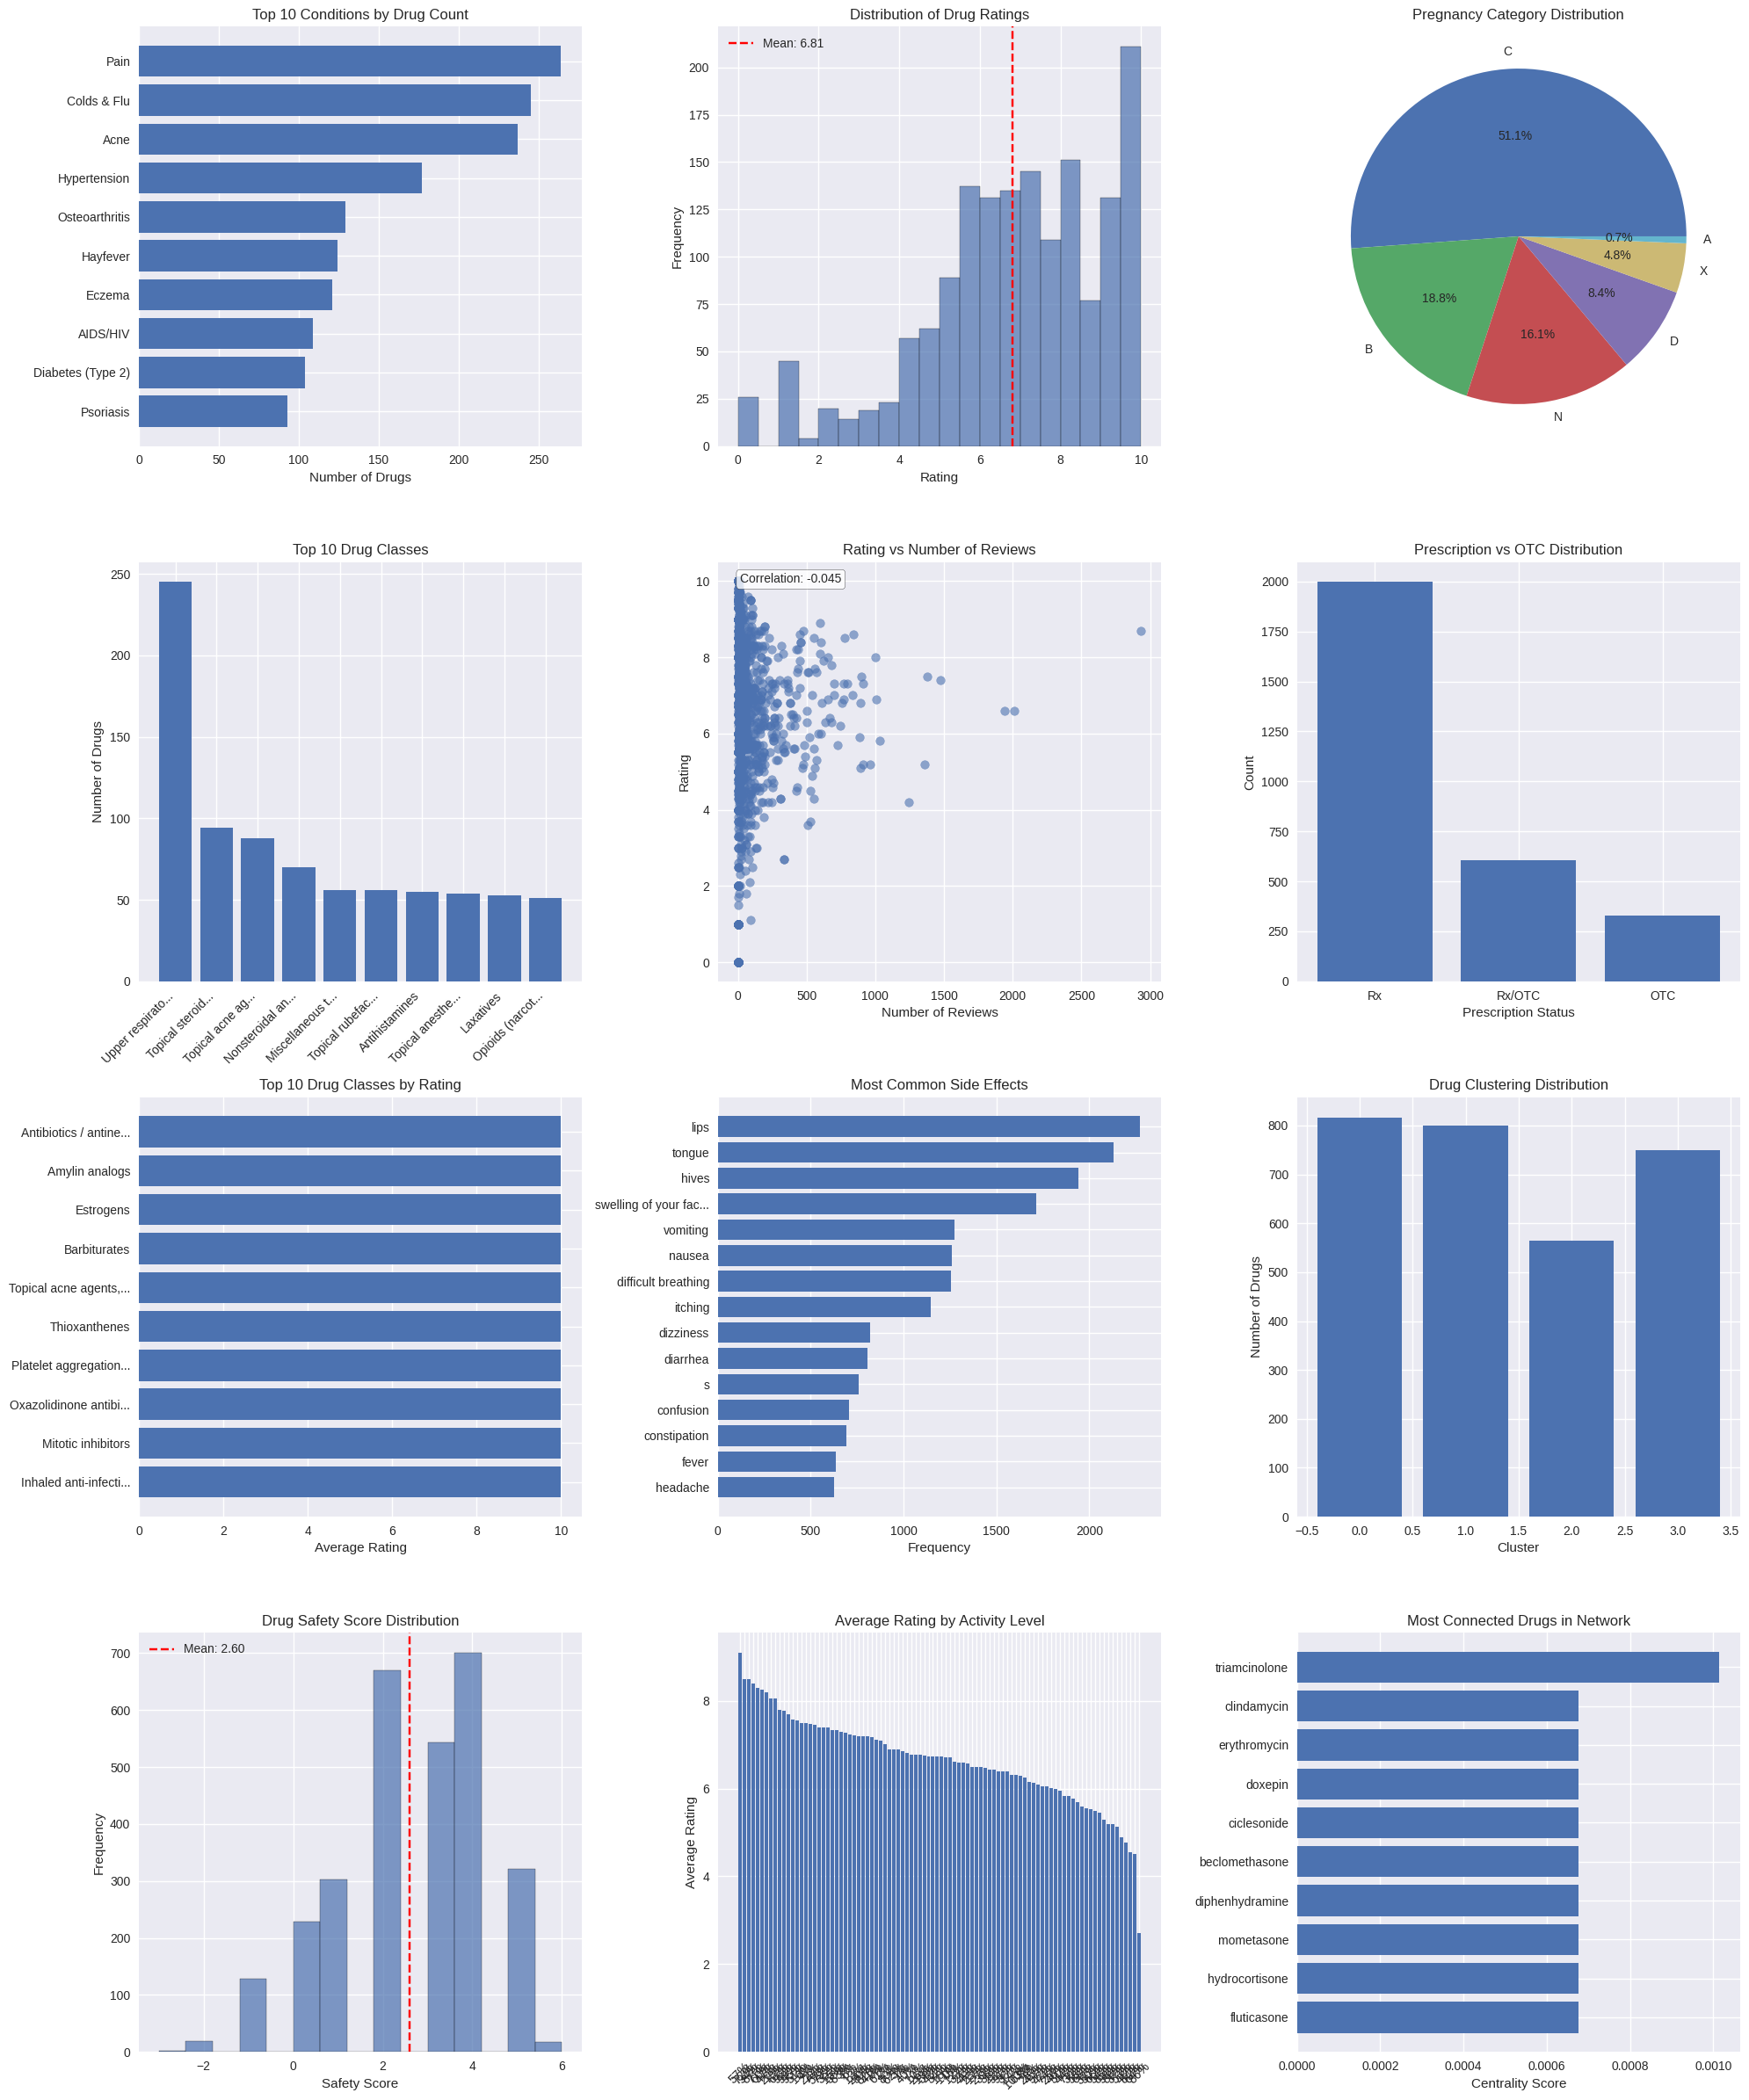

Comprehensive visualization saved as 'drug_analysis_comprehensive.png'

COMPREHENSIVE INSIGHTS REPORT
## DATASET OVERVIEW
• Total unique drugs analyzed: 2,912
• Total medical conditions covered: 47
• Total drug classes represented: 274
• Data completeness: 85.1%

## DRUG-CONDITION RELATIONSHIPS
• Most treated condition: 'Pain' with 264 different drug options
• 15 drugs treat multiple conditions (versatile medications)
• Most versatile drug: 'triamcinolone' treats 3 different conditions

## RATING AND REVIEW INSIGHTS
• Average drug rating: 6.81/10 (median: 7.00)
• Total user reviews analyzed: 119,053.0
• High-rated drugs (≥8.0): 570 (19.4%)
• Low-rated drugs (≤4.0): 168 (5.7%)
• Best-rated drug class: 'Antibiotics / antineoplastics' (avg: 10.00)

## SAFETY PROFILE INSIGHTS
• Most common pregnancy category: C
• Pregnancy-safe drugs (A/B categories): 527/2702 (19.5%)
• Controlled substances: 218, Non-controlled: 2688

## SIDE EFFECTS INSIGHTS
• Most common side effect: 'lips' (reported 22

In [2]:
# Basic usage
pipeline = DrugAnalysisPipeline("drugs_side_effects_drugs_com.csv")
pipeline.run_complete_analysis()